In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import json
import time
import sys

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE

from sklearn.neighbors import KNeighborsClassifier

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
covariate_key = 'sample'
print(f'Lataq model {covariate_key} as batch integration covariate')
print('load data')
condition_key = covariate_key
cell_type_key = ['predicted.celltype.l1']
adata = sc.read(
    '../../data/su_2020_rna.h5ad'
)
fred_full_meta = pd.read_csv('/lustre/groups/ml01/workspace/hediyehzadeh.s/shared_data/multigrate_multimil/notebooks/covid19_datasets_metadata_fredhutch.csv', index_col = 0)

datasetkey = 'su_2020'
fred_meta = fred_full_meta[fred_full_meta.dataset == datasetkey]
adata.obs = fred_meta


Lataq model sample as batch integration covariate
load data


/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (4,5,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [4]:
adata_tmp = adata.copy()
sc.pp.normalize_total(adata_tmp)
sc.pp.log1p(adata_tmp)
sc.pp.highly_variable_genes(
    adata_tmp, n_top_genes=2000, flavor="seurat_v3", subset=False
)
adata = adata[:, adata_tmp.var['highly_variable']]

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [24]:
PARAMS = {
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
}

In [ ]:
i = 1
for train_samples, _ in cv.split(adata.obs['sample'].unique()):
    sample_ref = adata.obs['sample'].unique()[train_samples]
    query_adata = adata[~adata.obs['sample'].isin(sample_ref)]
    labeled_idx = np.where(adata.obs['sample'].isin(sample_ref))[0]
    lataq_model = EMBEDCVAE(
        adata=adata,
        condition_key=condition_key,
        labeled_indices=labeled_idx,
        cell_type_keys=cell_type_key,
        hidden_layer_sizes=[128]*3,
        latent_dim=30,
        embedding_dim=20,
        inject_condition=['encoder', 'decoder']
    )
    lataq_model.train(
        n_epochs=50,
        pretraining_epochs=45,
        early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
        alpha_epoch_anneal=1e3,
        eta=1,
        clustering_res=2,
        weight_decay=0,
        use_stratified_sampling=False,
        best_reload=False,
    )
    lataq_model.save(f'model_refandquery_cv{i}', overwrite=True)

    lataq_model.model.eval()
    adata_emb = sc.AnnData(X=lataq_model.model.embedding.weight.detach().cpu().numpy())
    adata_emb.obs = adata.obs.groupby('sample').first().reindex(lataq_model.model.conditions)
    adata_emb.obs.disease_severity = adata_emb.obs.disease_severity.astype('string')
    adata_emb.obs.disease_severity[adata_emb.obs.disease_severity.isna()] = 'healthy'
    adata_emb.obs.disease_severity = adata_emb.obs.disease_severity.astype('category')
    adata_emb.obs['batch'] = '0'
    adata_emb.obs['batch'][~adata_emb.obs.index.isin(sample_ref)] = '1'
    for col in adata_emb.obs.columns:
        adata_emb.obs[col] = adata_emb.obs[col].astype(str)
    sc.pp.pca(adata_emb)
    adata_emb.write(f'embedding_cv{i}.h5ad')
    i += 1

In [5]:
df_list = []
for i in range(1, 6):
    print(i)
    adata_emb = sc.read(f'embedding_cv{i}.h5ad')
    adata_emb.obs['disease_clf'] = adata_emb.obs['disease_severity'].astype('string')
    adata_emb.obs['disease_clf'][adata_emb.obs['disease_clf'].isin(['healthy', 'mild'])] = 'healthy'
    adata_emb.obs['disease_clf'][~adata_emb.obs['disease_clf'].isin(['healthy', 'mild'])] = 'covid'                             
    adata_emb.obs['disease_clf'] = adata_emb.obs['disease_clf'].astype('category')
    adata_emb = adata_emb[adata_emb.obs['disease_severity']!='healthy']
    sc.pp.pca(adata_emb)
    X_train = adata_emb.X[adata_emb.obs['batch']=='0']
    X_test = adata_emb.X[adata_emb.obs['batch']=='1']
    y_train = adata_emb.obs['disease_severity'][adata_emb.obs['batch']=='0'].values
    y_test = adata_emb.obs['disease_severity'][adata_emb.obs['batch']=='1'].values
    clf = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    df_list.append(pd.DataFrame(classification_report(y_test, y_pred, target_names=clf.classes_, output_dict=True)))

1
2
3
4
5


In [6]:
df_scpoli = pd.concat(df_list)

In [7]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
adata_raw = sc.read(
    '../../data/su_2020_rna.h5ad'
)
fred_full_meta = pd.read_csv('/lustre/groups/ml01/workspace/hediyehzadeh.s/shared_data/multigrate_multimil/notebooks/covid19_datasets_metadata_fredhutch.csv', index_col = 0)
datasetkey = 'su_2020'
fred_meta = fred_full_meta[fred_full_meta.dataset == datasetkey]
adata_raw.obs = fred_meta
adata_raw.obs['disease_severity'][adata_raw.obs['disease_severity'].isna()] = 'healthy'

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (4,5,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-8-777ac6e6ee12>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_raw.obs['disease_severity'][adata_raw.obs['disease_severity'].isna()] = 'healthy'
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key

In [9]:
sc.pp.normalize_total(adata_raw)
sc.pp.log1p(adata_raw)
adata_raw = adata_raw[:, adata.var_names].copy()
adata_raw.obs['sample'] = adata_raw.obs['sample'].astype('category')
res = pd.DataFrame(columns=adata_raw.var_names, index=adata_raw.obs['sample'].cat.categories)                                                                                                 

for clust in adata_raw.obs['sample'].cat.categories: 
    res.loc[clust] = adata_raw[adata_raw.obs['sample'].isin([clust]),:].X.mean(0)
    
adata_mean = sc.AnnData(res.values)
adata_mean.obs = adata_raw.obs.groupby('sample').first()

<ipython-input-9-57873529a024>:10: FutureWarning: X.dtype being converted to np.float32 from object. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_mean = sc.AnnData(res.values)
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['1-1', '1-2', '10-1', '10-2', '100-1']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [10]:
i = 1
df_list = []
#adata_mean = adata_mean[adata_mean.obs['disease_severity']!='healthy']
for train_samples, _ in cv.split(adata_mean.obs.index.unique()):
    sample_ref = adata_mean.obs.index.unique()[train_samples]
    adata_mean.obs['batch'] = '0'
    adata_mean.obs['batch'][~adata_mean.obs.index.isin(sample_ref)] = '1'
    sc.pp.pca(adata_mean)
    X_train = adata_mean[adata_mean.obs['batch']=='0'].obsm['X_pca']
    X_test = adata_mean[adata_mean.obs['batch']=='1'].obsm['X_pca']
    y_train = adata_mean.obs['disease_severity'][adata_mean.obs['batch']=='0'].values
    y_test = adata_mean.obs['disease_severity'][adata_mean.obs['batch']=='1'].values
    clf = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    df_list.append(pd.DataFrame(classification_report(y_test, y_pred, target_names=clf.classes_, output_dict=True)))

<ipython-input-10-7a0c0a691c5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_mean.obs['batch'][~adata_mean.obs.index.isin(sample_ref)] = '1'
<ipython-input-10-7a0c0a691c5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_mean.obs['batch'][~adata_mean.obs.index.isin(sample_ref)] = '1'
<ipython-input-10-7a0c0a691c5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_mean.obs['batch'][~adata_mean.obs.index.isin(sampl

In [11]:
df_meangexp = pd.concat(df_list)

In [12]:
df_full = pd.concat([df_scpoli.assign(model='scPoli'), df_meangexp.assign(model='meanGE')])
df_full = df_full.loc['f1-score']

In [13]:
df_full.groupby('model').median()

,mild,moderate,severe,accuracy,macro avg,weighted avg,healthy
model,,,,,,,
meanGE,0.816327,0.585366,0.300000,0.611111,0.452167,0.602385,0.0
scPoli,0.809524,0.634146,0.307692,0.666667,0.580488,0.643095,NaN


In [41]:
(0.672 - 0.64) / 0.64 * 100

5.000000000000004

In [42]:
(0.667 - 0.611) / 0.611 * 100

9.165302782324067

In [43]:
(0.653 - 0.613) / 0.613 * 100

6.525285481239811

In [44]:
(0.643 - 0.59) / 0.613 * 100

8.646003262642749

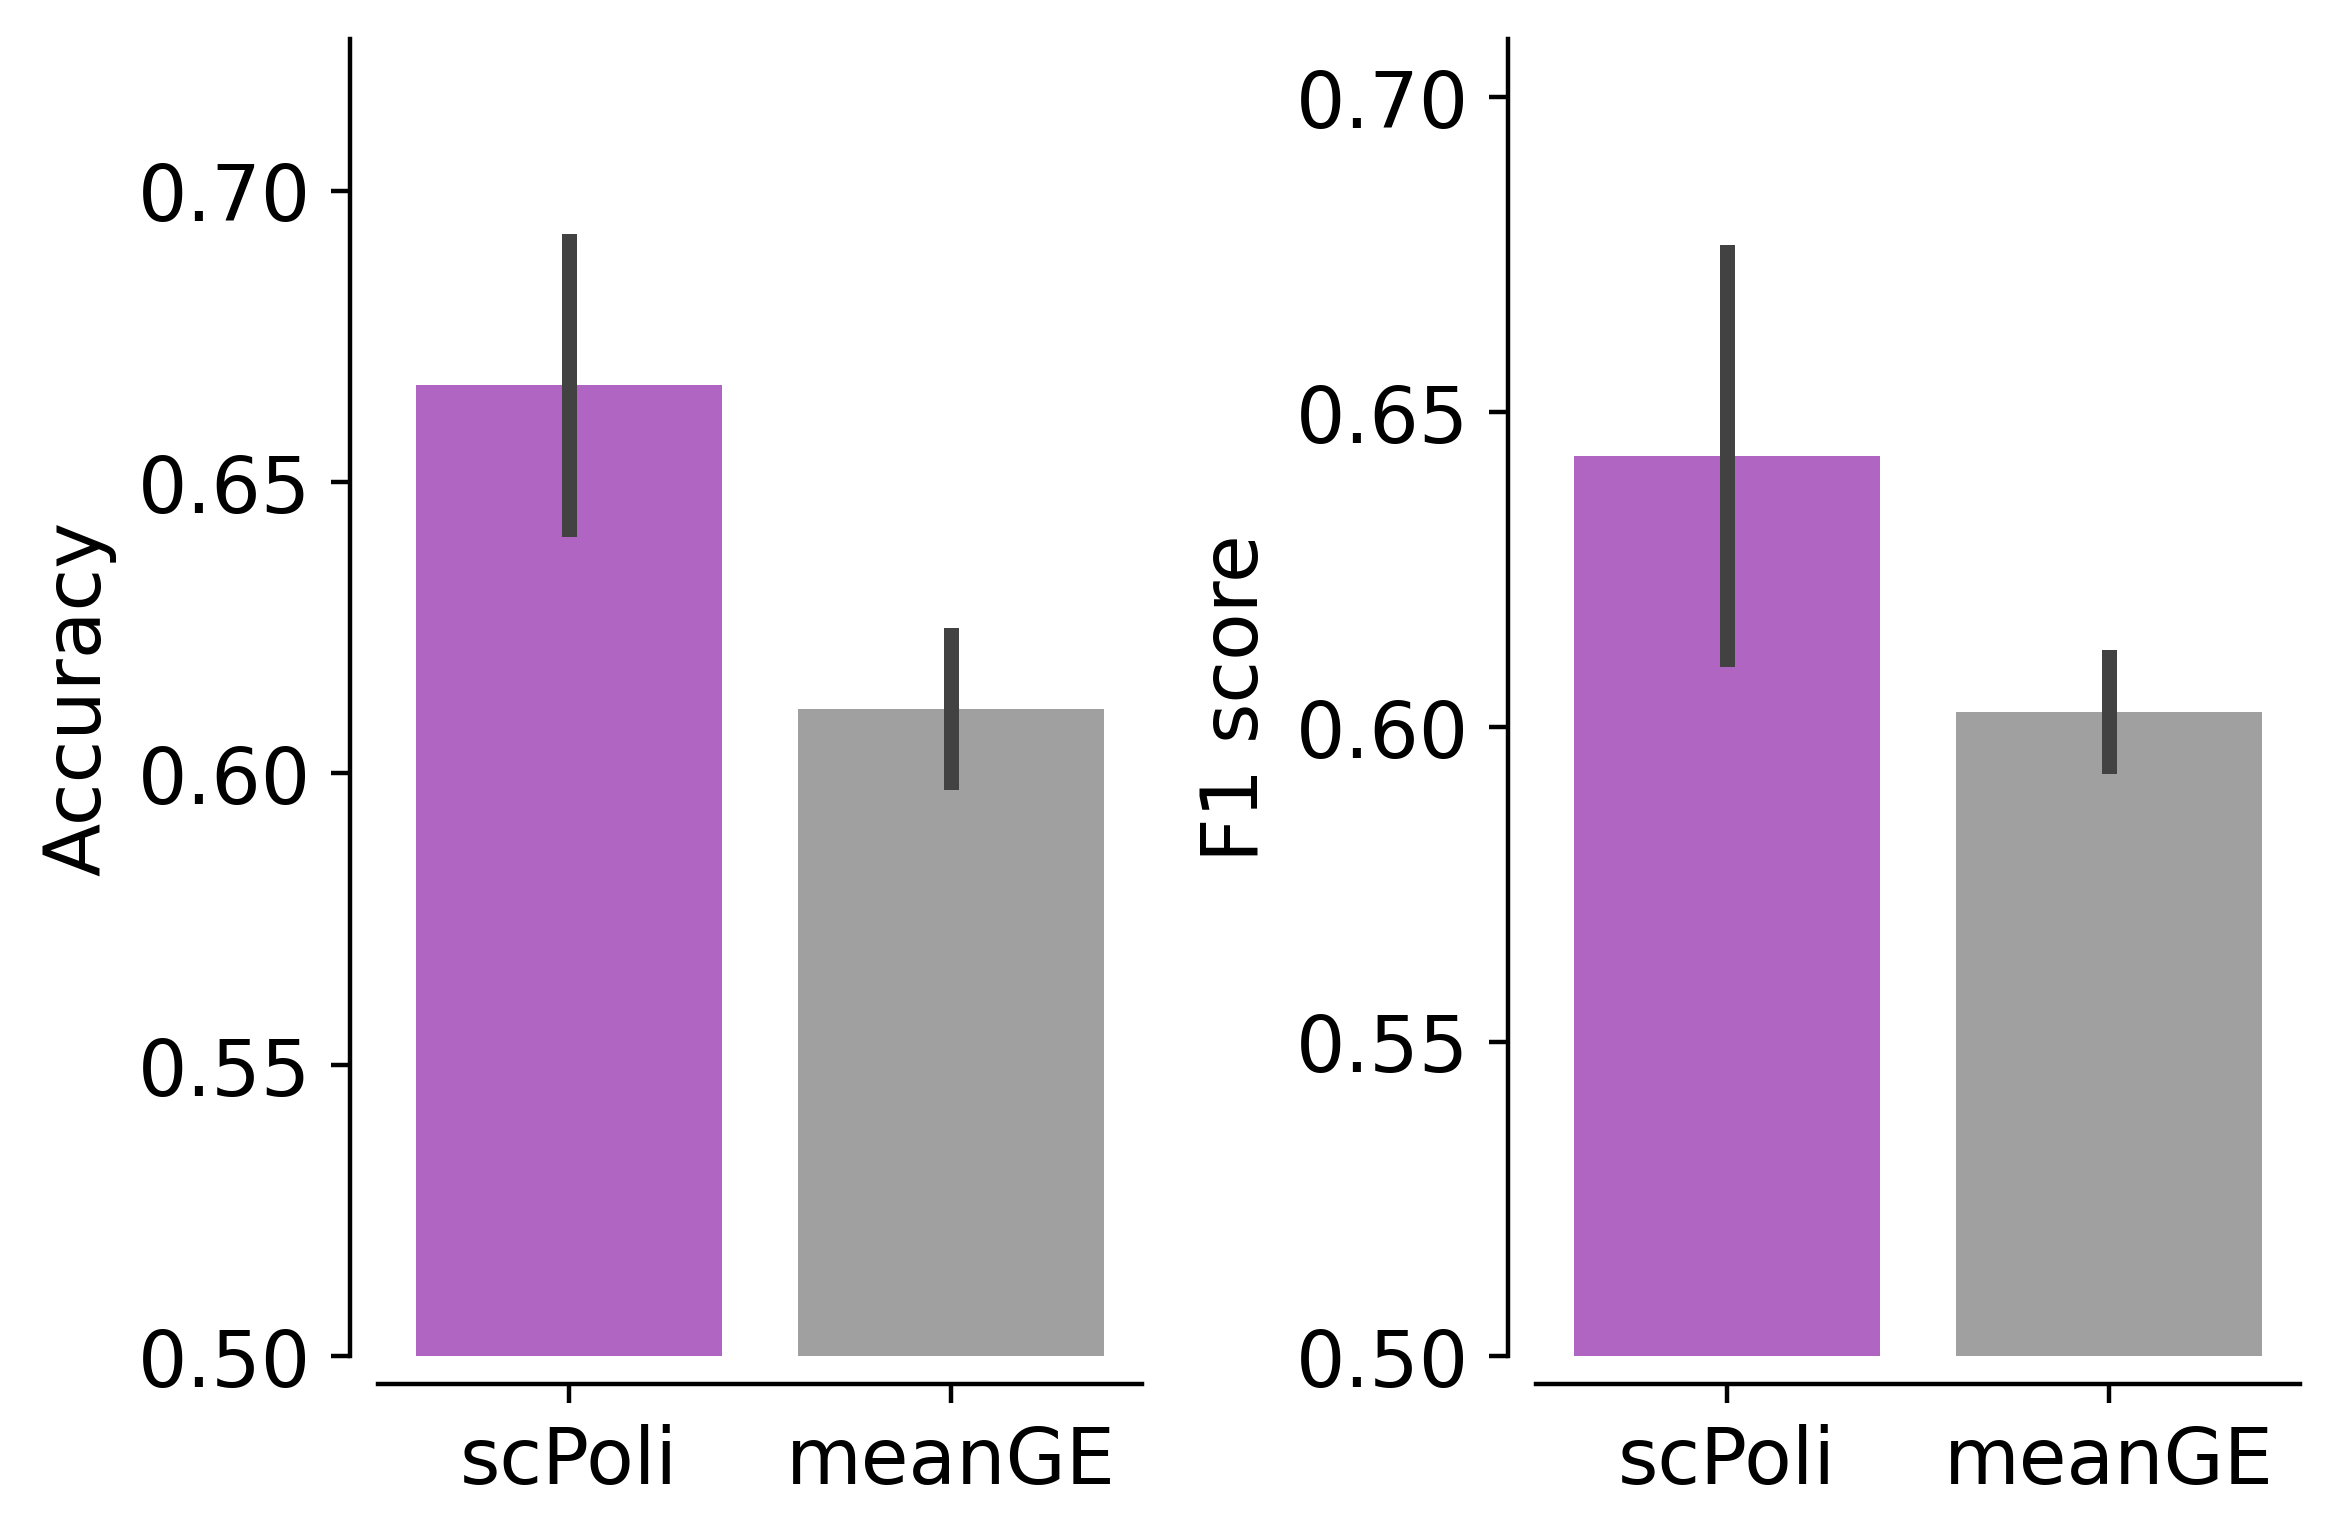

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=False)
sns.barplot(x='model', y='accuracy', data=df_full, estimator=np.median, errorbar='se', ax=ax[0], palette=['#BA55D3', '#A0A0A0'])
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[0])
ax[0].set_ylim(bottom=0.5)
ax[0].grid(False)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('')
sns.barplot(x='model', y='weighted avg', data=df_full, estimator=np.median, errorbar='se', ax=ax[1], palette=['#BA55D3', '#A0A0A0'])
#sns.swarmplot(x='model', y='accuracy', data=df_full, ax=ax[1])
ax[1].set_ylim(bottom=0.5)
ax[1].grid(False)
ax[1].set_ylabel('F1 score')
ax[1].set_xlabel('')
fig.tight_layout()
sns.despine(offset=5)
fig.savefig('classification_performance.png', dpi=400, bbox_inches='tight')